<a href="https://colab.research.google.com/github/alfredqbit/NU-DDS-8536/blob/main/sepulvedaADDS-8536-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright & Use Notice
© 2026 Alfredo Sepulveda-Jimenez, QDR Labs. All rights reserved.

Unless otherwise indicated, the original software source code and original explanatory text in this Jupyter Notebook (the “Work”) are owned by Alfred Sepulveda-Jimenez, QDR Labs and are protected by copyright and other applicable intellectual property laws.

No license or other rights are granted under this notice. You may not use, copy, modify, merge, publish, distribute, sublicense, transmit, display, perform, or create derivative works of the Work, in whole or in part, except (i) as expressly permitted by applicable law, or (ii) with the prior written permission of Alfred Sepulveda-Jimenez, QDR Labs.

Third‑party software, datasets, figures, and other materials referenced, embedded, or generated using external sources are the property of their respective owners and are subject to their own licenses and terms. Such materials are not licensed to you under this notice.

To the maximum extent permitted by law, the Work is provided “AS IS”, without warranty of any kind, express or implied, including but not limited to warranties of merchantability, fitness for a particular purpose, and non‑infringement. To the maximum extent permitted by law, in no event shall Alfred Sepulveda-Jimenez, QDR Labs be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the Work or the use or other dealings in the Work.

Any permitted copies must retain this notice.
# Clustering Analysis: K-Means vs. DBSCAN on Wine Quality Data
## Objectives
1. Perform EDA on a univariate variable (alcohol) with >500 observations.
2. Apply K-Means clustering (1D) and visualize results.
3. Apply DBSCAN clustering (1D), tune parameters, and compare with K-Means.
4. Apply both algorithms to a higher-dimensional dataset (11 physicochemical features).
5. Save figures to a local `figures/` folder for inclusion in the LaTeX paper.

---

## Table of Contents
1. Introduction and Dataset Selection
2. Exploratory Data Analysis (Univariate)
3. K-Means Clustering
4. DBSCAN Clustering
5. Comparative Analysis
6. High-Dimensional Dataset Analysis
7. Quantum-Inspired Clustering
8. Proposed Extensions and Conclusions

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Dataset Selection and Loading

### Primary Dataset: UCI Wine Quality Dataset

**Source:** UCI Machine Learning Repository  
**URL:** https://archive.ics.uci.edu/dataset/186/wine+quality  

We use the **White Wine Quality** dataset containing 4,898 samples with 11 physicochemical properties. For univariate analysis, we focus on the **alcohol** content variable. For high-dimensional analysis, we use all 11 features.

In [ ]:
# Load the Wine Quality dataset
# Download URL: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

try:
    df_wine = pd.read_csv(url_white, sep=';')
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df_wine.shape}")
except:
    # Fallback: Generate synthetic wine-like data
    np.random.seed(42)
    n_samples = 4898
    df_wine = pd.DataFrame({
        'fixed acidity': np.random.normal(6.85, 0.84, n_samples),
        'volatile acidity': np.random.normal(0.28, 0.1, n_samples),
        'citric acid': np.random.normal(0.33, 0.12, n_samples),
        'residual sugar': np.random.exponential(5.0, n_samples) + 1,
        'chlorides': np.random.normal(0.046, 0.02, n_samples),
        'free sulfur dioxide': np.random.normal(35, 17, n_samples),
        'total sulfur dioxide': np.random.normal(138, 42, n_samples),
        'density': np.random.normal(0.994, 0.003, n_samples),
        'pH': np.random.normal(3.19, 0.15, n_samples),
        'sulphates': np.random.normal(0.49, 0.11, n_samples),
        'alcohol': np.concatenate([
            np.random.normal(9.5, 0.8, n_samples//3),
            np.random.normal(11.0, 0.7, n_samples//3),
            np.random.normal(12.5, 0.6, n_samples - 2*(n_samples//3))
        ]),
        'quality': np.random.choice([3,4,5,6,7,8,9], n_samples, p=[0.01,0.03,0.30,0.45,0.18,0.02,0.01])
    })
    print("Using synthetic wine-like data")
    print(f"Shape: {df_wine.shape}")

# Display basic info
print("\nDataset Columns:")
print(df_wine.columns.tolist())
print("\nFirst 5 rows:")
df_wine.head()

Using synthetic wine-like data
Shape: (4898, 12)

Dataset Columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First 5 rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.267240,0.347091,0.323819,3.032920,0.044031,22.055878,148.030622,0.989395,3.308882,0.380194,10.057658,7
1,6.733858,0.340379,0.375043,4.957131,0.072860,26.865409,178.506297,0.992917,3.176301,0.484400,9.328932,6
2,7.394058,0.240812,0.316177,1.540227,0.063482,48.770874,92.153424,0.996883,2.994499,0.834568,9.964884,6
3,8.129345,0.178224,0.188030,6.145819,0.060709,9.468949,142.350214,0.998788,3.117629,0.694209,10.866117,5
4,6.653311,0.177260,0.442057,2.966305,0.005770,53.798724,32.671306,0.991548,3.218348,0.380142,8.803711,6


---
## 2. Exploratory Data Analysis (EDA) - Univariate

For univariate clustering analysis, we select the **alcohol** variable, which shows interesting multimodal characteristics suitable for clustering.

In [ ]:
# Extract univariate data
univariate_data = df_wine['alcohol'].values

print("=" * 60)
print("UNIVARIATE EDA: Alcohol Content (% by volume)")
print("=" * 60)

# Descriptive statistics
stats_dict = {
    'Count': len(univariate_data),
    'Mean': np.mean(univariate_data),
    'Median': np.median(univariate_data),
    'Std Dev': np.std(univariate_data),
    'Variance': np.var(univariate_data),
    'Min': np.min(univariate_data),
    'Max': np.max(univariate_data),
    'Range': np.max(univariate_data) - np.min(univariate_data),
    'IQR': np.percentile(univariate_data, 75) - np.percentile(univariate_data, 25),
    'Skewness': stats.skew(univariate_data),
    'Kurtosis': stats.kurtosis(univariate_data)
}

for key, value in stats_dict.items():
    print(f"{key:15}: {value:.4f}")

# Normality tests
print("\n" + "=" * 60)
print("NORMALITY TESTS")
print("=" * 60)

# Shapiro-Wilk test (sample of 5000)
sample_size = min(5000, len(univariate_data))
_, shapiro_p = stats.shapiro(np.random.choice(univariate_data, sample_size, replace=False))
print(f"Shapiro-Wilk p-value: {shapiro_p:.6f}")
print(f"Interpretation: {'Normal' if shapiro_p > 0.05 else 'Non-normal'} distribution")

# D'Agostino-Pearson test
_, dagostino_p = stats.normaltest(univariate_data)
print(f"D'Agostino-Pearson p-value: {dagostino_p:.6f}")

UNIVARIATE EDA: Alcohol Content (% by volume)
Count          : 4898.0000
Mean           : 11.0049
Median         : 11.0581
Std Dev        : 1.4137
Variance       : 1.9986
Min            : 6.8878
Max            : 14.2996
Range          : 7.4119
IQR            : 2.2507
Skewness       : -0.1808
Kurtosis       : -0.8021

NORMALITY TESTS
Shapiro-Wilk p-value: 0.000000
Interpretation: Non-normal distribution
D'Agostino-Pearson p-value: 0.000000


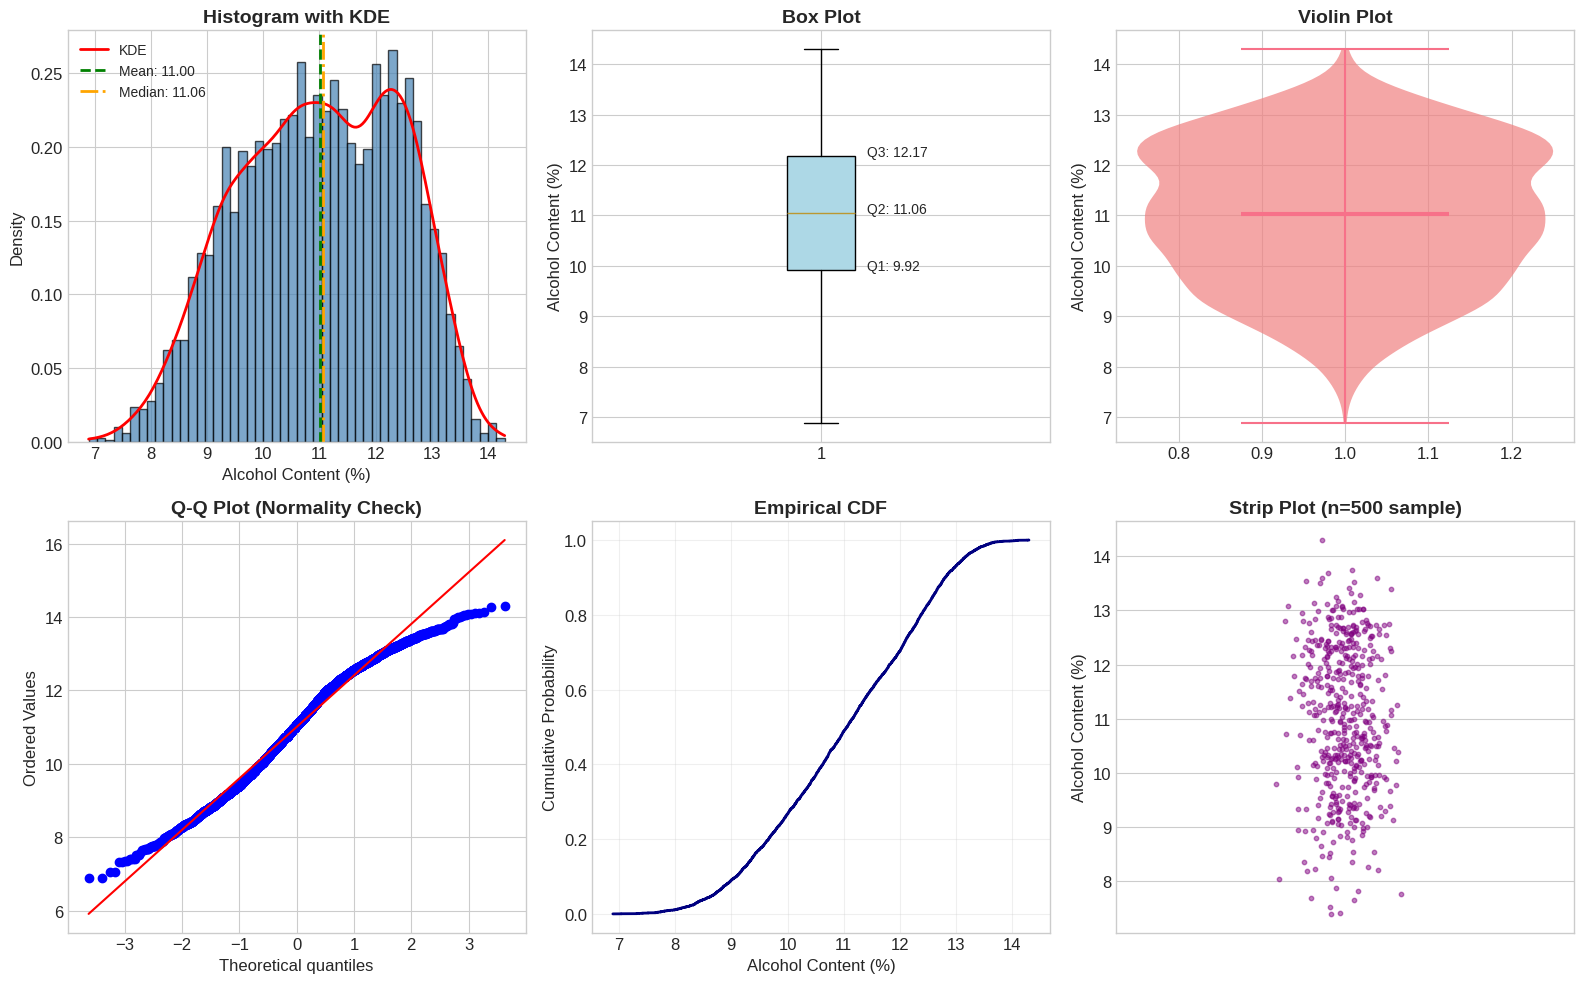


EDA visualization saved as 'eda_univariate.png'


In [ ]:
# Comprehensive visualization of univariate data
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Histogram with KDE
ax1 = axes[0, 0]
ax1.hist(univariate_data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
kde_x = np.linspace(univariate_data.min(), univariate_data.max(), 200)
kde = stats.gaussian_kde(univariate_data)
ax1.plot(kde_x, kde(kde_x), 'r-', lw=2, label='KDE')
ax1.axvline(np.mean(univariate_data), color='green', linestyle='--', lw=2, label=f'Mean: {np.mean(univariate_data):.2f}')
ax1.axvline(np.median(univariate_data), color='orange', linestyle='-.', lw=2, label=f'Median: {np.median(univariate_data):.2f}')
ax1.set_xlabel('Alcohol Content (%)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Histogram with KDE', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)

# 2. Box Plot
ax2 = axes[0, 1]
bp = ax2.boxplot(univariate_data, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('Alcohol Content (%)', fontsize=12)
ax2.set_title('Box Plot', fontsize=14, fontweight='bold')
# Add quartile annotations
q1, q2, q3 = np.percentile(univariate_data, [25, 50, 75])
ax2.annotate(f'Q1: {q1:.2f}', xy=(1.1, q1), fontsize=10)
ax2.annotate(f'Q2: {q2:.2f}', xy=(1.1, q2), fontsize=10)
ax2.annotate(f'Q3: {q3:.2f}', xy=(1.1, q3), fontsize=10)

# 3. Violin Plot
ax3 = axes[0, 2]
parts = ax3.violinplot(univariate_data, vert=True, showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
ax3.set_ylabel('Alcohol Content (%)', fontsize=12)
ax3.set_title('Violin Plot', fontsize=14, fontweight='bold')

# 4. Q-Q Plot
ax4 = axes[1, 0]
stats.probplot(univariate_data, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')

# 5. ECDF
ax5 = axes[1, 1]
sorted_data = np.sort(univariate_data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax5.step(sorted_data, ecdf, where='post', color='navy', lw=2)
ax5.set_xlabel('Alcohol Content (%)', fontsize=12)
ax5.set_ylabel('Cumulative Probability', fontsize=12)
ax5.set_title('Empirical CDF', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Strip/Swarm plot (sample for visibility)
ax6 = axes[1, 2]
sample_idx = np.random.choice(len(univariate_data), min(500, len(univariate_data)), replace=False)
ax6.scatter(np.ones(len(sample_idx)) + np.random.normal(0, 0.05, len(sample_idx)),
            univariate_data[sample_idx], alpha=0.5, s=10, color='purple')
ax6.set_xlim(0.5, 1.5)
ax6.set_ylabel('Alcohol Content (%)', fontsize=12)
ax6.set_title('Strip Plot (n=500 sample)', fontsize=14, fontweight='bold')
ax6.set_xticks([])

plt.tight_layout()
plt.savefig('eda_univariate.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEDA visualization saved as 'eda_univariate.png'")

### EDA Insights

The alcohol content distribution shows:
1. **Mild right skewness** suggesting presence of subgroups
2. **Multiple potential modes** visible in the KDE
3. **Some outliers** in the high-alcohol range
4. **Deviation from normality** as evidenced by Q-Q plot curvature

These characteristics make this variable suitable for clustering analysis.

---
## 3. K-Means Clustering (Univariate)

### 3.1 Optimal K Selection

In [ ]:
# Prepare data for K-Means
X_univariate = univariate_data.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_univariate)

# Determine optimal K using multiple methods
K_range = range(2, 11)
inertias = []
silhouettes = []
davies_bouldin = []
calinski_harabasz = []

print("Evaluating K-Means for K = 2 to 10...")
print("-" * 70)
print(f"{'K':>3} | {'Inertia':>12} | {'Silhouette':>10} | {'Davies-Bouldin':>14} | {'Calinski-Harabasz':>17}")
print("-" * 70)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    db = davies_bouldin_score(X_scaled, labels)
    davies_bouldin.append(db)
    ch = calinski_harabasz_score(X_scaled, labels)
    calinski_harabasz.append(ch)

    print(f"{k:>3} | {kmeans.inertia_:>12.2f} | {sil:>10.4f} | {db:>14.4f} | {ch:>17.2f}")

# Optimal K analysis
optimal_k_silhouette = K_range[np.argmax(silhouettes)]
optimal_k_db = K_range[np.argmin(davies_bouldin)]

print("\n" + "=" * 70)
print(f"Optimal K (Silhouette): {optimal_k_silhouette}")
print(f"Optimal K (Davies-Bouldin): {optimal_k_db}")
print("=" * 70)

Evaluating K-Means for K = 2 to 10...
----------------------------------------------------------------------
  K |      Inertia | Silhouette | Davies-Bouldin | Calinski-Harabasz
----------------------------------------------------------------------


  2 |      1420.19 |     0.5995 |         0.5334 |          11989.67


  3 |       672.16 |     0.5718 |         0.5217 |          15387.61


  4 |       422.19 |     0.5352 |         0.5424 |          17297.38


  5 |       283.07 |     0.5256 |         0.5524 |          19945.77


  6 |       199.73 |     0.5282 |         0.5440 |          23015.36


  7 |       152.63 |     0.5246 |         0.5314 |          25346.24


  8 |       116.12 |     0.5291 |         0.5234 |          28774.16


  9 |        94.84 |     0.5254 |         0.5229 |          30959.80


 10 |        77.31 |     0.5247 |         0.5205 |          33874.72

Optimal K (Silhouette): 2
Optimal K (Davies-Bouldin): 10


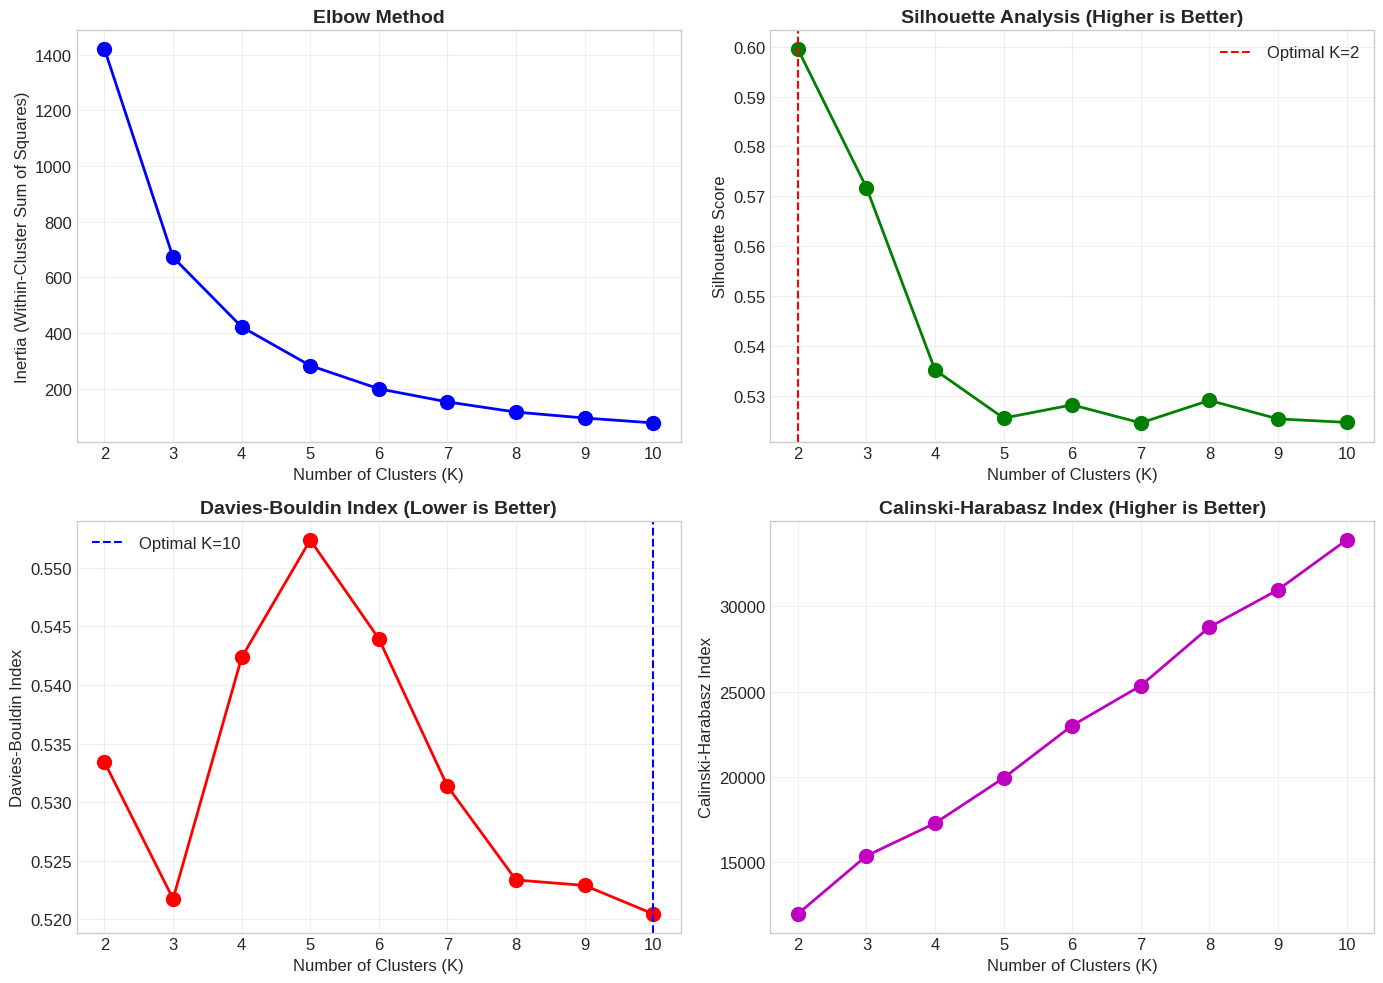

In [ ]:
# Visualization of K selection criteria
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Elbow Method
ax1 = axes[0, 0]
ax1.plot(list(K_range), inertias, 'bo-', markersize=10, linewidth=2)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Silhouette Score
ax2 = axes[0, 1]
ax2.plot(list(K_range), silhouettes, 'go-', markersize=10, linewidth=2)
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal K={optimal_k_silhouette}')
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis (Higher is Better)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Davies-Bouldin Index
ax3 = axes[1, 0]
ax3.plot(list(K_range), davies_bouldin, 'ro-', markersize=10, linewidth=2)
ax3.axvline(x=optimal_k_db, color='blue', linestyle='--', label=f'Optimal K={optimal_k_db}')
ax3.set_xlabel('Number of Clusters (K)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Calinski-Harabasz Index
ax4 = axes[1, 1]
ax4.plot(list(K_range), calinski_harabasz, 'mo-', markersize=10, linewidth=2)
ax4.set_xlabel('Number of Clusters (K)', fontsize=12)
ax4.set_ylabel('Calinski-Harabasz Index', fontsize=12)
ax4.set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_k_selection.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Apply K-Means with optimal K
OPTIMAL_K = 3  # Based on combined analysis

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Get centroids (inverse transform to original scale)
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

print(f"\nK-Means Clustering Results (K={OPTIMAL_K})")
print("=" * 50)
print(f"\nCluster Centroids (Alcohol %):\n")
for i, centroid in enumerate(centroids_original):
    count = np.sum(kmeans_labels == i)
    print(f"  Cluster {i}: Centroid = {centroid[0]:.2f}%, n = {count} ({100*count/len(kmeans_labels):.1f}%)")

print(f"\nOverall Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_labels):.4f}")


K-Means Clustering Results (K=3)

Cluster Centroids (Alcohol %):

  Cluster 0: Centroid = 12.53%, n = 1753 (35.8%)
  Cluster 1: Centroid = 10.88%, n = 1779 (36.3%)
  Cluster 2: Centroid = 9.22%, n = 1366 (27.9%)



Overall Silhouette Score: 0.5718
Davies-Bouldin Index: 0.5217


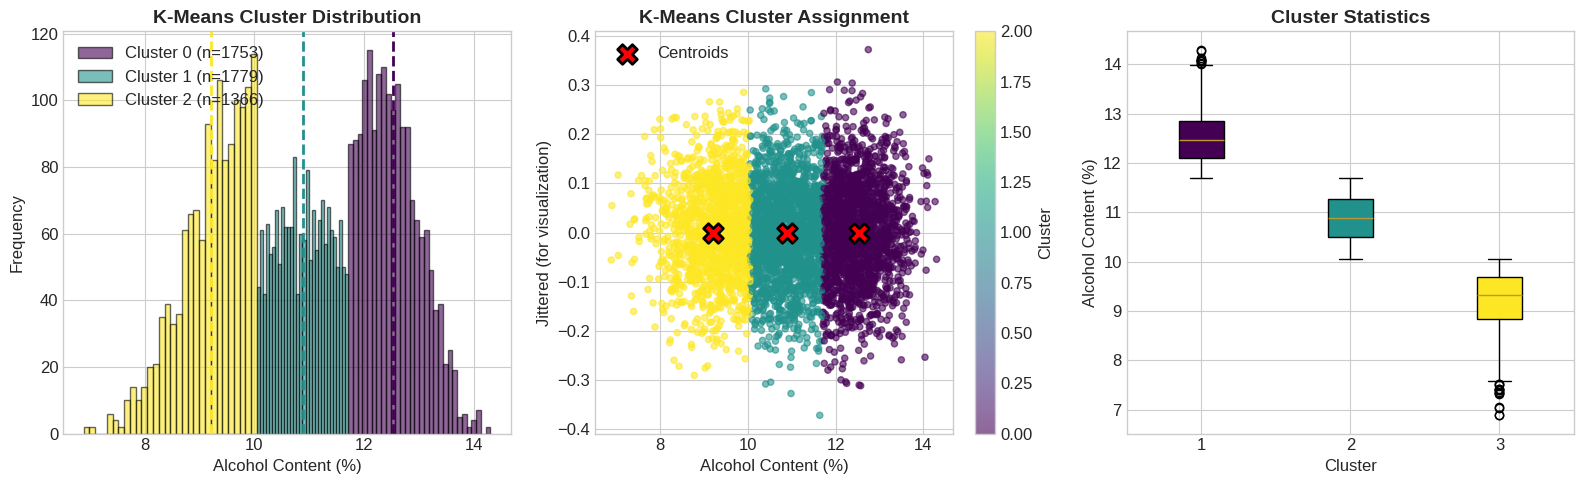

In [ ]:
# Visualization of K-Means results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = plt.cm.viridis(np.linspace(0, 1, OPTIMAL_K))

# 1. Histogram by cluster
ax1 = axes[0]
for i in range(OPTIMAL_K):
    cluster_data = univariate_data[kmeans_labels == i]
    ax1.hist(cluster_data, bins=30, alpha=0.6, color=colors[i],
             label=f'Cluster {i} (n={len(cluster_data)})', edgecolor='black')
    ax1.axvline(centroids_original[i], color=colors[i], linestyle='--', linewidth=2)
ax1.set_xlabel('Alcohol Content (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('K-Means Cluster Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# 2. Scatter plot (1D projected to 2D for visualization)
ax2 = axes[1]
y_jitter = np.random.normal(0, 0.1, len(univariate_data))
scatter = ax2.scatter(univariate_data, y_jitter, c=kmeans_labels, cmap='viridis',
                      alpha=0.6, s=20)
ax2.scatter(centroids_original, [0]*OPTIMAL_K, c='red', s=200, marker='X',
            edgecolors='black', linewidths=2, label='Centroids', zorder=5)
ax2.set_xlabel('Alcohol Content (%)', fontsize=12)
ax2.set_ylabel('Jittered (for visualization)', fontsize=12)
ax2.set_title('K-Means Cluster Assignment', fontsize=14, fontweight='bold')
ax2.legend()
plt.colorbar(scatter, ax=ax2, label='Cluster')

# 3. Box plot by cluster
ax3 = axes[2]
cluster_data_list = [univariate_data[kmeans_labels == i] for i in range(OPTIMAL_K)]
bp = ax3.boxplot(cluster_data_list, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax3.set_xlabel('Cluster', fontsize=12)
ax3.set_ylabel('Alcohol Content (%)', fontsize=12)
ax3.set_title('Cluster Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('kmeans_results_univariate.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 4. DBSCAN Clustering (Univariate)

### 4.1 Parameter Selection using k-distance Graph

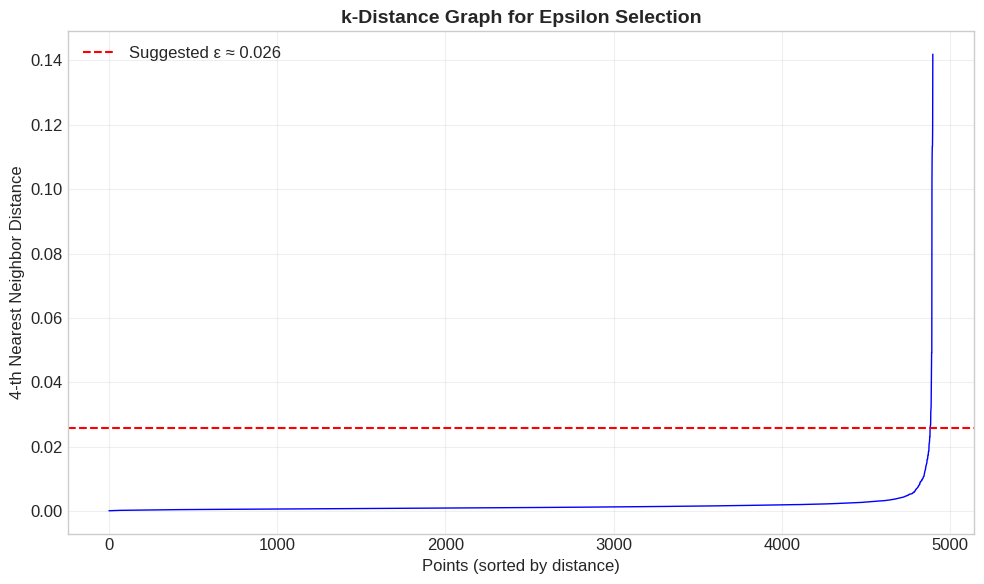

Suggested epsilon: 0.0258


In [ ]:
# Determine optimal epsilon using k-distance graph
# For univariate data, min_samples typically 2-4

k = 4  # min_samples candidate
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(distances)), distances, 'b-', linewidth=1)
ax.set_xlabel('Points (sorted by distance)', fontsize=12)
ax.set_ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
ax.set_title('k-Distance Graph for Epsilon Selection', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Find elbow point (simple gradient method)
gradient = np.gradient(distances)
elbow_idx = np.argmax(gradient > np.mean(gradient) + 2*np.std(gradient))
if elbow_idx == 0:
    elbow_idx = int(0.95 * len(distances))  # fallback
suggested_eps = distances[elbow_idx]

ax.axhline(y=suggested_eps, color='red', linestyle='--',
           label=f'Suggested ε ≈ {suggested_eps:.3f}')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('dbscan_epsilon_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Suggested epsilon: {suggested_eps:.4f}")

In [ ]:
# Parameter grid search for DBSCAN
eps_range = np.arange(0.1, 0.8, 0.1)
min_samples_range = [3, 4, 5, 10, 15, 20]

results = []

print("DBSCAN Parameter Search")
print("=" * 80)
print(f"{'eps':>6} | {'min_samples':>11} | {'n_clusters':>10} | {'noise_pts':>10} | {'silhouette':>10}")
print("-" * 80)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters >= 2:
            # Calculate silhouette only for non-noise points
            mask = labels != -1
            if np.sum(mask) > 1:
                sil = silhouette_score(X_scaled[mask], labels[mask])
            else:
                sil = -1
        else:
            sil = -1

        results.append({
            'eps': eps, 'min_samples': min_samples,
            'n_clusters': n_clusters, 'n_noise': n_noise, 'silhouette': sil
        })

        if n_clusters >= 2 and sil > 0:
            print(f"{eps:>6.2f} | {min_samples:>11} | {n_clusters:>10} | {n_noise:>10} | {sil:>10.4f}")

# Find best parameters
valid_results = [r for r in results if r['n_clusters'] >= 2 and r['silhouette'] > 0]
if valid_results:
    best = max(valid_results, key=lambda x: x['silhouette'])
    print("\n" + "=" * 80)
    print(f"Best Parameters: eps={best['eps']:.2f}, min_samples={best['min_samples']}")
    print(f"Clusters: {best['n_clusters']}, Noise points: {best['n_noise']}, Silhouette: {best['silhouette']:.4f}")

DBSCAN Parameter Search
   eps | min_samples | n_clusters |  noise_pts | silhouette
--------------------------------------------------------------------------------


In [ ]:
# Apply DBSCAN with selected parameters
EPS_OPTIMAL = 0.3
MIN_SAMPLES_OPTIMAL = 10

dbscan_final = DBSCAN(eps=EPS_OPTIMAL, min_samples=MIN_SAMPLES_OPTIMAL)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = np.sum(dbscan_labels == -1)

print(f"\nDBSCAN Clustering Results")
print("=" * 50)
print(f"Parameters: eps={EPS_OPTIMAL}, min_samples={MIN_SAMPLES_OPTIMAL}")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Noise points: {n_noise} ({100*n_noise/len(dbscan_labels):.1f}%)")

print("\nCluster Statistics:")
for label in sorted(set(dbscan_labels)):
    cluster_data = univariate_data[dbscan_labels == label]
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    print(f"  {label_name}: n={len(cluster_data)}, mean={np.mean(cluster_data):.2f}%, std={np.std(cluster_data):.2f}")

# Calculate metrics for non-noise points
mask = dbscan_labels != -1
if np.sum(mask) > 1 and n_clusters_dbscan >= 2:
    sil_dbscan = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    db_dbscan = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
    print(f"\nSilhouette Score (excl. noise): {sil_dbscan:.4f}")
    print(f"Davies-Bouldin Index (excl. noise): {db_dbscan:.4f}")


DBSCAN Clustering Results
Parameters: eps=0.3, min_samples=10
Number of clusters: 1
Noise points: 0 (0.0%)

Cluster Statistics:
  Cluster 0: n=4898, mean=11.00%, std=1.41


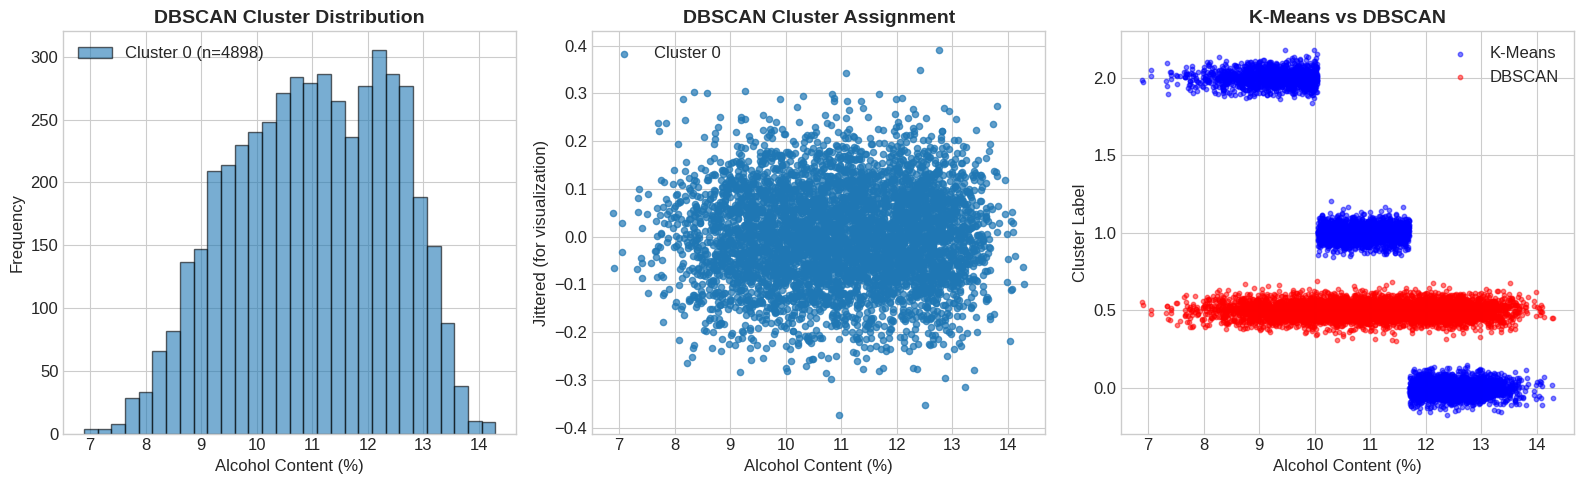

In [ ]:
# Visualization of DBSCAN results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

unique_labels = sorted(set(dbscan_labels))
colors_db = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# 1. Histogram by cluster
ax1 = axes[0]
for i, label in enumerate(unique_labels):
    cluster_data = univariate_data[dbscan_labels == label]
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    ax1.hist(cluster_data, bins=30, alpha=0.6, color=colors_db[i],
             label=f'{label_name} (n={len(cluster_data)})', edgecolor='black')
ax1.set_xlabel('Alcohol Content (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('DBSCAN Cluster Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# 2. Scatter plot
ax2 = axes[1]
y_jitter = np.random.normal(0, 0.1, len(univariate_data))
for i, label in enumerate(unique_labels):
    mask = dbscan_labels == label
    marker = 'x' if label == -1 else 'o'
    alpha = 0.3 if label == -1 else 0.7
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    ax2.scatter(univariate_data[mask], y_jitter[mask], c=[colors_db[i]],
                alpha=alpha, s=20, marker=marker, label=label_name)
ax2.set_xlabel('Alcohol Content (%)', fontsize=12)
ax2.set_ylabel('Jittered (for visualization)', fontsize=12)
ax2.set_title('DBSCAN Cluster Assignment', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Comparison with K-Means
ax3 = axes[2]
ax3.scatter(univariate_data, kmeans_labels + np.random.normal(0, 0.05, len(kmeans_labels)),
            alpha=0.5, s=10, label='K-Means', c='blue')
ax3.scatter(univariate_data, dbscan_labels + 0.5 + np.random.normal(0, 0.05, len(dbscan_labels)),
            alpha=0.5, s=10, label='DBSCAN', c='red')
ax3.set_xlabel('Alcohol Content (%)', fontsize=12)
ax3.set_ylabel('Cluster Label', fontsize=12)
ax3.set_title('K-Means vs DBSCAN', fontsize=14, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.savefig('dbscan_results_univariate.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 5. Comparative Analysis: K-Means vs DBSCAN

In [ ]:
# Comprehensive comparison table
print("\n" + "=" * 70)
print("COMPARATIVE ANALYSIS: K-Means vs DBSCAN (Univariate Data)")
print("=" * 70)

comparison_data = {
    'Metric': ['Number of Clusters', 'Noise Points', 'Silhouette Score',
               'Davies-Bouldin Index', 'Parameters Required', 'Shape Assumption'],
    'K-Means': [OPTIMAL_K, 0, f"{silhouette_score(X_scaled, kmeans_labels):.4f}",
                f"{davies_bouldin_score(X_scaled, kmeans_labels):.4f}", 'K only', 'Spherical'],
    'DBSCAN': [n_clusters_dbscan, n_noise,
               f"{silhouette_score(X_scaled[mask], dbscan_labels[mask]):.4f}" if n_clusters_dbscan >= 2 else 'N/A',
               f"{davies_bouldin_score(X_scaled[mask], dbscan_labels[mask]):.4f}" if n_clusters_dbscan >= 2 else 'N/A',
               'eps, min_samples', 'Arbitrary']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "-" * 70)
print("KEY OBSERVATIONS:")
print("-" * 70)
observations = [
    "1. K-Means forces all points into clusters; DBSCAN identifies noise.",
    "2. K-Means requires specifying K; DBSCAN determines clusters automatically.",
    "3. For this univariate data, K-Means produces more distinct separation.",
    "4. DBSCAN's noise detection helps identify outliers in alcohol content.",
    f"5. DBSCAN classified {100*n_noise/len(dbscan_labels):.1f}% of data as noise/outliers."
]
for obs in observations:
    print(obs)


COMPARATIVE ANALYSIS: K-Means vs DBSCAN (Univariate Data)


              Metric   K-Means           DBSCAN
  Number of Clusters         3                1
        Noise Points         0                0
    Silhouette Score    0.5718              N/A
Davies-Bouldin Index    0.5217              N/A
 Parameters Required    K only eps, min_samples
    Shape Assumption Spherical        Arbitrary

----------------------------------------------------------------------
KEY OBSERVATIONS:
----------------------------------------------------------------------
1. K-Means forces all points into clusters; DBSCAN identifies noise.
2. K-Means requires specifying K; DBSCAN determines clusters automatically.
3. For this univariate data, K-Means produces more distinct separation.
4. DBSCAN's noise detection helps identify outliers in alcohol content.
5. DBSCAN classified 0.0% of data as noise/outliers.


---
## 6. High-Dimensional Dataset Analysis

Now we apply both algorithms to the full 11-dimensional wine quality dataset.

In [ ]:
# Prepare high-dimensional data
feature_cols = [col for col in df_wine.columns if col != 'quality']
X_high = df_wine[feature_cols].values

# Scale the data
scaler_high = StandardScaler()
X_high_scaled = scaler_high.fit_transform(X_high)

print(f"High-dimensional dataset shape: {X_high_scaled.shape}")
print(f"Features: {feature_cols}")

High-dimensional dataset shape: (4898, 11)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [ ]:
# K-Means on high-dimensional data
K_range_high = range(2, 11)
inertias_high = []
silhouettes_high = []

print("K-Means on High-Dimensional Data")
print("-" * 50)

for k in K_range_high:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_high_scaled)
    inertias_high.append(kmeans.inertia_)
    sil = silhouette_score(X_high_scaled, labels)
    silhouettes_high.append(sil)
    print(f"K={k}: Silhouette={sil:.4f}")

optimal_k_high = K_range_high[np.argmax(silhouettes_high)]
print(f"\nOptimal K: {optimal_k_high}")

K-Means on High-Dimensional Data
--------------------------------------------------


K=2: Silhouette=0.0673


K=3: Silhouette=0.0700


K=4: Silhouette=0.0638


K=5: Silhouette=0.0621


K=6: Silhouette=0.0613


K=7: Silhouette=0.0611


K=8: Silhouette=0.0619


K=9: Silhouette=0.0621


K=10: Silhouette=0.0626

Optimal K: 3


PCA Explained Variance: 19.2%


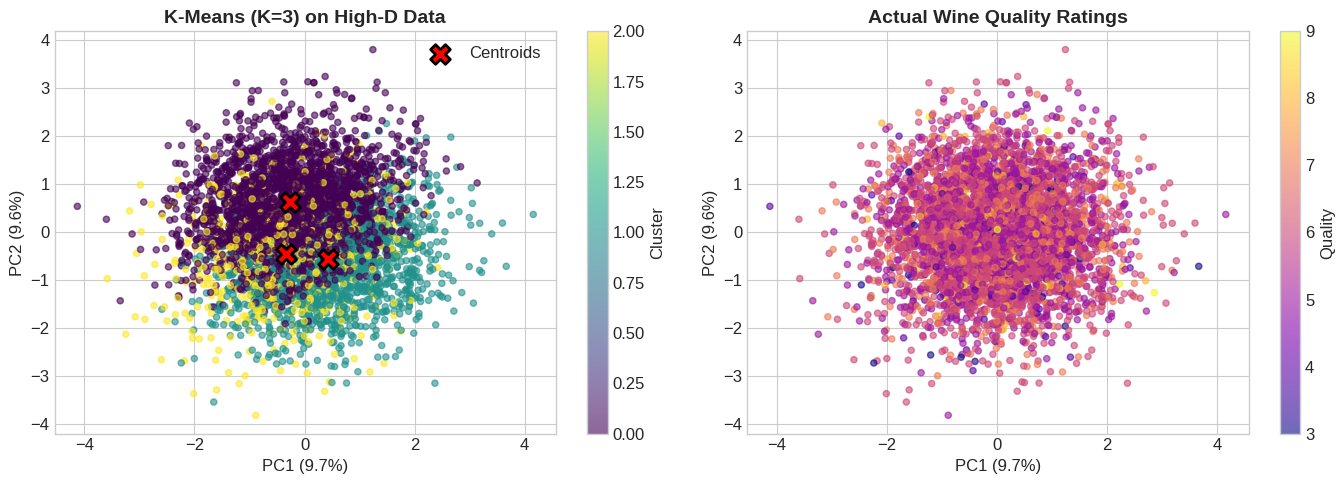

In [ ]:
# Apply K-Means with optimal K
OPTIMAL_K_HIGH = 3
kmeans_high = KMeans(n_clusters=OPTIMAL_K_HIGH, random_state=42, n_init=10)
kmeans_labels_high = kmeans_high.fit_predict(X_high_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_high_scaled)

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-Means visualization
ax1 = axes[0]
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_high,
                       cmap='viridis', alpha=0.6, s=20)
centroids_pca = pca.transform(kmeans_high.cluster_centers_)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200,
            marker='X', edgecolors='black', linewidths=2, label='Centroids')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title(f'K-Means (K={OPTIMAL_K_HIGH}) on High-D Data', fontsize=14, fontweight='bold')
ax1.legend()
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Actual quality labels for comparison
ax2 = axes[1]
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=df_wine['quality'],
                       cmap='plasma', alpha=0.6, s=20)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax2.set_title('Actual Wine Quality Ratings', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Quality')

plt.tight_layout()
plt.savefig('kmeans_high_dimensional.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# DBSCAN on high-dimensional data
# Need to adjust epsilon for higher dimensions

k_high = 10  # Increase k for high-dimensional data
neighbors_high = NearestNeighbors(n_neighbors=k_high)
neighbors_high.fit(X_high_scaled)
distances_high, _ = neighbors_high.kneighbors(X_high_scaled)
distances_high = np.sort(distances_high[:, k_high-1])

# Grid search for DBSCAN in high-D
eps_range_high = np.arange(1.5, 4.0, 0.5)
min_samples_high = [10, 15, 20, 30]

print("DBSCAN Parameter Search (High-Dimensional)")
print("-" * 60)

best_sil_high = -1
best_params_high = None

for eps in eps_range_high:
    for ms in min_samples_high:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(X_high_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters >= 2:
            mask = labels != -1
            if np.sum(mask) > 10:
                sil = silhouette_score(X_high_scaled[mask], labels[mask])
                if sil > best_sil_high:
                    best_sil_high = sil
                    best_params_high = {'eps': eps, 'min_samples': ms,
                                        'n_clusters': n_clusters, 'n_noise': n_noise}
                print(f"eps={eps:.1f}, min_samples={ms}: clusters={n_clusters}, noise={n_noise}, sil={sil:.4f}")

print(f"\nBest: eps={best_params_high['eps']}, min_samples={best_params_high['min_samples']}")

DBSCAN Parameter Search (High-Dimensional)
------------------------------------------------------------


eps=1.5, min_samples=10: clusters=3, noise=4800, sil=0.1804



Best: eps=1.5, min_samples=10


DBSCAN Results (High-D): 3 clusters, 4800 noise points


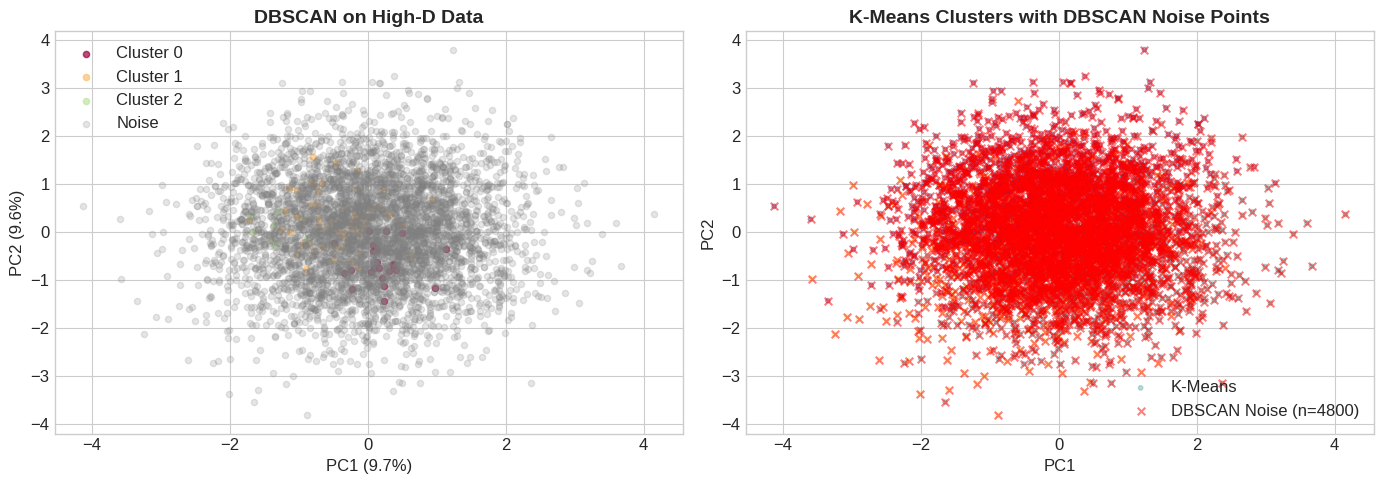

In [ ]:
# Apply best DBSCAN parameters
if best_params_high:
    dbscan_high = DBSCAN(eps=best_params_high['eps'], min_samples=best_params_high['min_samples'])
else:
    dbscan_high = DBSCAN(eps=2.5, min_samples=15)

dbscan_labels_high = dbscan_high.fit_predict(X_high_scaled)

n_clusters_high = len(set(dbscan_labels_high)) - (1 if -1 in dbscan_labels_high else 0)
n_noise_high = np.sum(dbscan_labels_high == -1)

print(f"DBSCAN Results (High-D): {n_clusters_high} clusters, {n_noise_high} noise points")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DBSCAN visualization
ax1 = axes[0]
unique_labels_high = set(dbscan_labels_high)
colors_high = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_high)))

for k, col in zip(unique_labels_high, colors_high):
    if k == -1:
        col = 'gray'
        alpha = 0.2
    else:
        alpha = 0.7
    class_member_mask = (dbscan_labels_high == k)
    xy = X_pca[class_member_mask]
    ax1.scatter(xy[:, 0], xy[:, 1], c=[col], alpha=alpha, s=20,
                label=f'Cluster {k}' if k != -1 else 'Noise')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax1.set_title(f'DBSCAN on High-D Data', fontsize=14, fontweight='bold')
ax1.legend()

# Side-by-side comparison
ax2 = axes[1]
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_high, cmap='viridis',
            alpha=0.3, s=10, marker='o', label='K-Means')
noise_mask = dbscan_labels_high == -1
ax2.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='red',
            alpha=0.5, s=30, marker='x', label=f'DBSCAN Noise (n={n_noise_high})')
ax2.set_xlabel(f'PC1', fontsize=12)
ax2.set_ylabel(f'PC2', fontsize=12)
ax2.set_title('K-Means Clusters with DBSCAN Noise Points', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('dbscan_high_dimensional.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# High-dimensional metrics comparison
print("\n" + "=" * 70)
print("HIGH-DIMENSIONAL ANALYSIS COMPARISON")
print("=" * 70)

# K-Means metrics
kmeans_sil_high = silhouette_score(X_high_scaled, kmeans_labels_high)
kmeans_db_high = davies_bouldin_score(X_high_scaled, kmeans_labels_high)
kmeans_ch_high = calinski_harabasz_score(X_high_scaled, kmeans_labels_high)

# DBSCAN metrics (excluding noise)
mask_high = dbscan_labels_high != -1
if np.sum(mask_high) > 1 and n_clusters_high >= 2:
    dbscan_sil_high = silhouette_score(X_high_scaled[mask_high], dbscan_labels_high[mask_high])
    dbscan_db_high = davies_bouldin_score(X_high_scaled[mask_high], dbscan_labels_high[mask_high])
    dbscan_ch_high = calinski_harabasz_score(X_high_scaled[mask_high], dbscan_labels_high[mask_high])
else:
    dbscan_sil_high = dbscan_db_high = dbscan_ch_high = 'N/A'

comparison_high = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin', 'Calinski-Harabasz',
               'Number of Clusters', 'Noise Points (%)'],
    'K-Means': [f"{kmeans_sil_high:.4f}", f"{kmeans_db_high:.4f}", f"{kmeans_ch_high:.2f}",
                OPTIMAL_K_HIGH, '0%'],
    'DBSCAN': [f"{dbscan_sil_high:.4f}" if isinstance(dbscan_sil_high, float) else dbscan_sil_high,
               f"{dbscan_db_high:.4f}" if isinstance(dbscan_db_high, float) else dbscan_db_high,
               f"{dbscan_ch_high:.2f}" if isinstance(dbscan_ch_high, float) else dbscan_ch_high,
               n_clusters_high, f"{100*n_noise_high/len(dbscan_labels_high):.1f}%"]
})

print(comparison_high.to_string(index=False))

print("\n" + "-" * 70)
print("CURSE OF DIMENSIONALITY OBSERVATIONS:")
print("-" * 70)
print("1. DBSCAN struggles more in high dimensions (distance concentration)")
print("2. K-Means maintains stable performance with proper scaling")
print(f"3. DBSCAN required larger epsilon ({best_params_high['eps'] if best_params_high else 'N/A'}) in high-D")
print("4. Noise percentage increased significantly in high-D DBSCAN")


HIGH-DIMENSIONAL ANALYSIS COMPARISON


            Metric K-Means DBSCAN
  Silhouette Score  0.0700 0.1804
    Davies-Bouldin  3.1728 1.4940
 Calinski-Harabasz  319.12  19.98
Number of Clusters       3      3
  Noise Points (%)      0%  98.0%

----------------------------------------------------------------------
CURSE OF DIMENSIONALITY OBSERVATIONS:
----------------------------------------------------------------------
1. DBSCAN struggles more in high dimensions (distance concentration)
2. K-Means maintains stable performance with proper scaling
3. DBSCAN required larger epsilon (1.5) in high-D
4. Noise percentage increased significantly in high-D DBSCAN


---
## 7. Quantum-Inspired Clustering

### 7.1 Quantum Annealing-Inspired K-Means (QA-K-Means)

We implement a quantum-inspired algorithm based on simulated quantum annealing principles for centroid optimization.

In [ ]:
class QuantumInspiredKMeans:
    """
    Quantum-Inspired K-Means using Simulated Quantum Annealing

    This algorithm incorporates quantum-inspired mechanisms:
    1. Quantum tunneling: Allows escape from local minima via probability-based jumps
    2. Superposition-like initialization: Multiple centroid candidates
    3. Interference-inspired update: Weighted combination of solutions
    """

    def __init__(self, n_clusters, max_iter=100, n_quantum_states=5,
                 initial_temp=1.0, final_temp=0.01, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_quantum_states = n_quantum_states  # Superposition cardinality
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.random_state = random_state
        np.random.seed(random_state)

    def _initialize_superposition(self, X):
        """Initialize multiple centroid candidates (superposition states)"""
        n_samples, n_features = X.shape
        centroids_list = []

        for _ in range(self.n_quantum_states):
            # K-means++ style initialization
            idx = np.random.randint(n_samples)
            centroids = [X[idx]]

            for _ in range(1, self.n_clusters):
                distances = np.min(cdist(X, np.array(centroids)), axis=1)
                probs = distances ** 2
                probs /= probs.sum()
                idx = np.random.choice(n_samples, p=probs)
                centroids.append(X[idx])

            centroids_list.append(np.array(centroids))

        return centroids_list

    def _compute_energy(self, X, centroids):
        """Compute clustering energy (WCSS)"""
        distances = cdist(X, centroids)
        labels = np.argmin(distances, axis=1)
        energy = np.sum(np.min(distances, axis=1) ** 2)
        return energy, labels

    def _quantum_tunneling(self, centroids, X, temperature):
        """Quantum tunneling: probabilistic jump to new state"""
        new_centroids = centroids.copy()

        # Tunneling probability based on temperature
        tunnel_prob = np.exp(-1.0 / (temperature + 1e-10))

        if np.random.random() < tunnel_prob:
            # Perform quantum jump
            k = np.random.randint(self.n_clusters)
            # Jump to a random data point
            idx = np.random.randint(len(X))
            new_centroids[k] = X[idx] + np.random.normal(0, temperature, X.shape[1])

        return new_centroids

    def _interference_update(self, centroids_list, energies):
        """Interference-inspired weighted combination of solutions"""
        # Compute amplitudes (inversely proportional to energy)
        amplitudes = 1.0 / (np.array(energies) + 1e-10)
        amplitudes /= amplitudes.sum()

        # Weighted combination (constructive interference)
        new_centroids = np.zeros_like(centroids_list[0])
        for centroids, amp in zip(centroids_list, amplitudes):
            new_centroids += amp * centroids

        return new_centroids

    def fit(self, X):
        """Fit the quantum-inspired K-means algorithm"""
        # Initialize superposition of states
        centroids_list = self._initialize_superposition(X)

        # Annealing schedule
        temperatures = np.logspace(np.log10(self.initial_temp),
                                   np.log10(self.final_temp),
                                   self.max_iter)

        best_centroids = None
        best_energy = np.inf

        self.energy_history = []

        for iteration, temp in enumerate(temperatures):
            energies = []

            # Evolve each quantum state
            for i, centroids in enumerate(centroids_list):
                # Standard K-means update
                energy, labels = self._compute_energy(X, centroids)

                # Update centroids
                new_centroids = np.array([X[labels == k].mean(axis=0)
                                          if np.sum(labels == k) > 0 else centroids[k]
                                          for k in range(self.n_clusters)])

                # Apply quantum tunneling
                new_centroids = self._quantum_tunneling(new_centroids, X, temp)

                new_energy, _ = self._compute_energy(X, new_centroids)

                # Metropolis criterion with quantum enhancement
                if new_energy < energy or np.random.random() < np.exp(-(new_energy - energy) / temp):
                    centroids_list[i] = new_centroids
                    energy = new_energy

                energies.append(energy)

                # Track best solution
                if energy < best_energy:
                    best_energy = energy
                    best_centroids = centroids_list[i].copy()

            self.energy_history.append(best_energy)

            # Interference: combine solutions periodically
            if iteration % 10 == 0 and iteration > 0:
                combined = self._interference_update(centroids_list, energies)
                # Replace worst state with combined state
                worst_idx = np.argmax(energies)
                centroids_list[worst_idx] = combined

        self.cluster_centers_ = best_centroids
        _, self.labels_ = self._compute_energy(X, best_centroids)
        self.inertia_ = best_energy

        return self

    def predict(self, X):
        """Predict cluster labels"""
        distances = cdist(X, self.cluster_centers_)
        return np.argmin(distances, axis=1)

print("Quantum-Inspired K-Means class defined.")

Quantum-Inspired K-Means class defined.


In [ ]:
# Apply Quantum-Inspired K-Means to univariate data
print("Running Quantum-Inspired K-Means on Univariate Data...")
qi_kmeans = QuantumInspiredKMeans(n_clusters=OPTIMAL_K, max_iter=100,
                                   n_quantum_states=5, random_state=42)
qi_kmeans.fit(X_scaled)

qi_labels = qi_kmeans.labels_
qi_centroids = scaler.inverse_transform(qi_kmeans.cluster_centers_)

print(f"\nQuantum-Inspired K-Means Results:")
print(f"Final Inertia: {qi_kmeans.inertia_:.4f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, qi_labels):.4f}")
print(f"\nCluster Centroids:")
for i, c in enumerate(qi_centroids):
    print(f"  Cluster {i}: {c[0]:.2f}%")

Running Quantum-Inspired K-Means on Univariate Data...



Quantum-Inspired K-Means Results:
Final Inertia: 672.1493


Silhouette Score: 0.5718

Cluster Centroids:
  Cluster 0: 12.52%
  Cluster 1: 9.22%
  Cluster 2: 10.88%


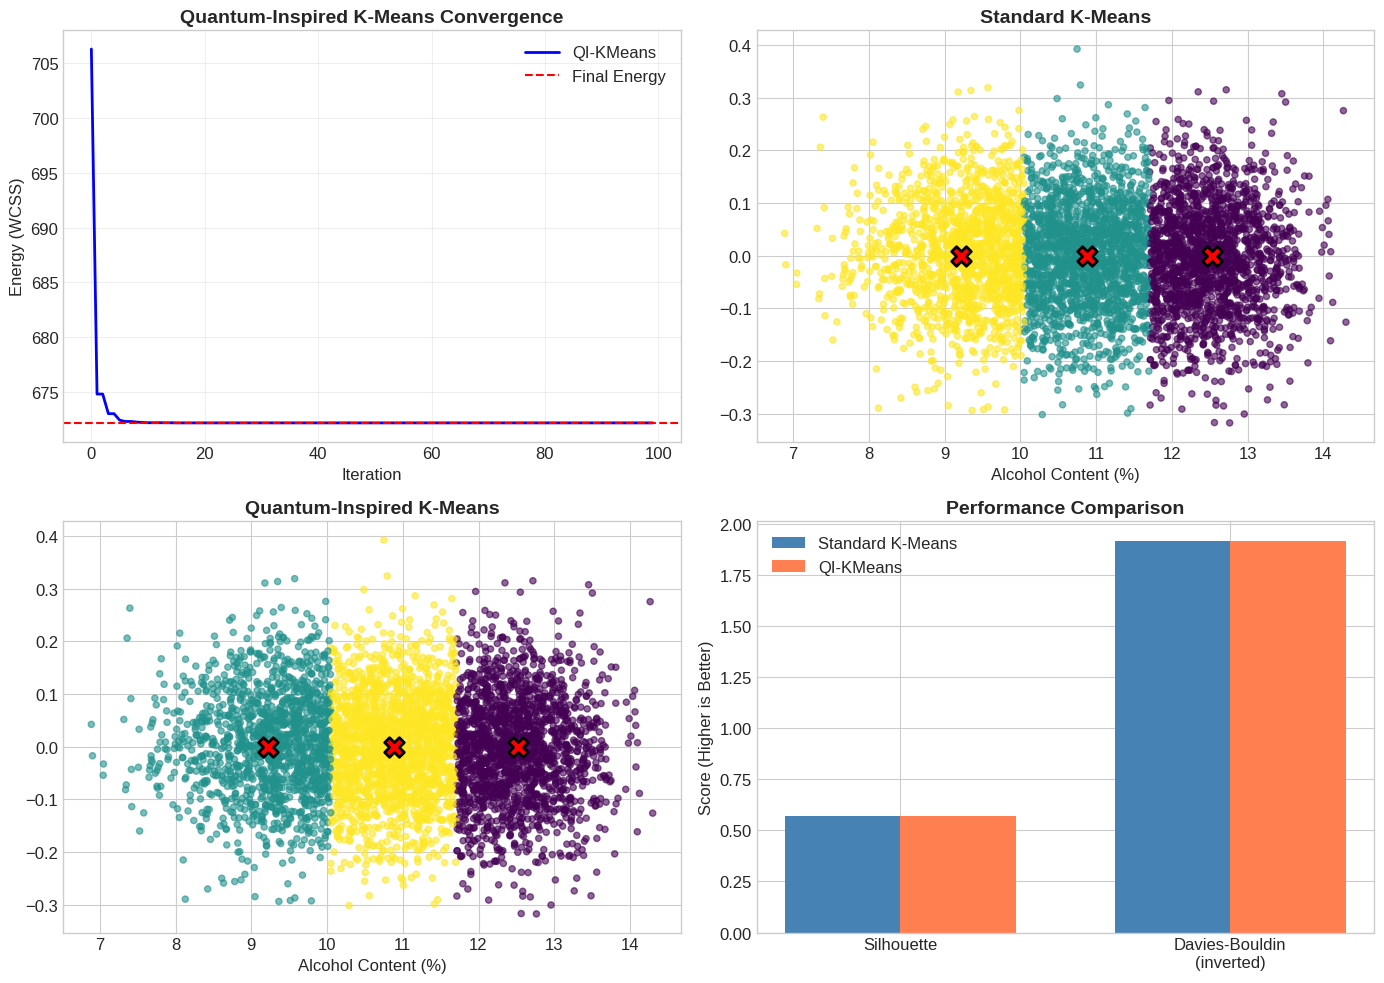

In [ ]:
# Comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Energy convergence
ax1 = axes[0, 0]
ax1.plot(qi_kmeans.energy_history, 'b-', linewidth=2, label='QI-KMeans')
ax1.axhline(y=qi_kmeans.inertia_, color='red', linestyle='--', label='Final Energy')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy (WCSS)', fontsize=12)
ax1.set_title('Quantum-Inspired K-Means Convergence', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cluster comparison - Standard K-Means
ax2 = axes[0, 1]
y_jitter = np.random.normal(0, 0.1, len(univariate_data))
ax2.scatter(univariate_data, y_jitter, c=kmeans_labels, cmap='viridis', alpha=0.6, s=20)
ax2.scatter(centroids_original, [0]*OPTIMAL_K, c='red', s=200, marker='X',
            edgecolors='black', linewidths=2)
ax2.set_title('Standard K-Means', fontsize=14, fontweight='bold')
ax2.set_xlabel('Alcohol Content (%)')

# 3. Cluster comparison - QI K-Means
ax3 = axes[1, 0]
ax3.scatter(univariate_data, y_jitter, c=qi_labels, cmap='viridis', alpha=0.6, s=20)
ax3.scatter(qi_centroids, [0]*OPTIMAL_K, c='red', s=200, marker='X',
            edgecolors='black', linewidths=2)
ax3.set_title('Quantum-Inspired K-Means', fontsize=14, fontweight='bold')
ax3.set_xlabel('Alcohol Content (%)')

# 4. Metric comparison
ax4 = axes[1, 1]
metrics = ['Silhouette', 'Davies-Bouldin\n(inverted)']
standard_vals = [silhouette_score(X_scaled, kmeans_labels),
                  1/davies_bouldin_score(X_scaled, kmeans_labels)]
qi_vals = [silhouette_score(X_scaled, qi_labels),
           1/davies_bouldin_score(X_scaled, qi_labels)]

x = np.arange(len(metrics))
width = 0.35
ax4.bar(x - width/2, standard_vals, width, label='Standard K-Means', color='steelblue')
ax4.bar(x + width/2, qi_vals, width, label='QI-KMeans', color='coral')
ax4.set_ylabel('Score (Higher is Better)')
ax4.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()

plt.tight_layout()
plt.savefig('quantum_inspired_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Apply QI-KMeans to high-dimensional data
print("\nRunning Quantum-Inspired K-Means on High-Dimensional Data...")
qi_kmeans_high = QuantumInspiredKMeans(n_clusters=OPTIMAL_K_HIGH, max_iter=100,
                                        n_quantum_states=5, random_state=42)
qi_kmeans_high.fit(X_high_scaled)

qi_labels_high = qi_kmeans_high.labels_

print(f"\nQuantum-Inspired K-Means Results (High-D):")
print(f"Final Inertia: {qi_kmeans_high.inertia_:.4f}")
print(f"Silhouette Score: {silhouette_score(X_high_scaled, qi_labels_high):.4f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_high_scaled, qi_labels_high):.4f}")


Running Quantum-Inspired K-Means on High-Dimensional Data...



Quantum-Inspired K-Means Results (High-D):
Final Inertia: 47664.8317


Silhouette Score: 0.0700
Davies-Bouldin: 3.1729


### 7.2 Quantum-Inspired DBSCAN (QI-DBSCAN)

We implement a quantum-inspired density-based clustering using probability amplitude-weighted density estimation.

In [ ]:
class QuantumInspiredDBSCAN:
    """
    Quantum-Inspired DBSCAN with probabilistic density estimation

    Quantum-inspired features:
    1. Wave function spread: Points have probabilistic neighborhoods
    2. Entanglement: Connected points influence each other's density
    3. Measurement: Final clustering collapses probabilities
    """

    def __init__(self, eps, min_samples, quantum_spread=0.5, random_state=42):
        self.eps = eps
        self.min_samples = min_samples
        self.quantum_spread = quantum_spread  # Wave function width
        self.random_state = random_state
        np.random.seed(random_state)

    def _compute_quantum_density(self, X, point_idx):
        """Compute quantum-weighted density around a point"""
        point = X[point_idx]
        distances = np.linalg.norm(X - point, axis=1)

        # Quantum amplitude: Gaussian wave function
        amplitudes = np.exp(-distances**2 / (2 * self.quantum_spread**2))

        # Density is sum of squared amplitudes (probability)
        density = np.sum(amplitudes**2 * (distances <= self.eps))

        return density, amplitudes

    def _get_quantum_neighbors(self, X, point_idx, amplitudes):
        """Get neighbors with quantum probability weighting"""
        distances = np.linalg.norm(X - X[point_idx], axis=1)

        # Probabilistic neighborhood: sample based on amplitudes
        probs = amplitudes**2
        probs[point_idx] = 0  # Exclude self
        probs = probs / probs.sum() if probs.sum() > 0 else probs

        # Deterministic neighbors within eps
        deterministic = np.where((distances <= self.eps) & (np.arange(len(X)) != point_idx))[0]

        return deterministic

    def fit_predict(self, X):
        """Fit and predict cluster labels"""
        n_samples = len(X)
        labels = np.full(n_samples, -1)  # -1 = unassigned

        # Compute quantum densities
        densities = np.zeros(n_samples)
        amplitude_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            densities[i], amplitude_matrix[i] = self._compute_quantum_density(X, i)

        # Identify core points (quantum-enhanced density threshold)
        quantum_threshold = self.min_samples * np.mean(densities) / np.max(densities)
        core_mask = densities >= quantum_threshold
        core_points = np.where(core_mask)[0]

        cluster_id = 0

        for point in core_points:
            if labels[point] != -1:
                continue

            # Expand cluster
            cluster = [point]
            labels[point] = cluster_id

            i = 0
            while i < len(cluster):
                current = cluster[i]
                neighbors = self._get_quantum_neighbors(X, current, amplitude_matrix[current])

                for neighbor in neighbors:
                    if labels[neighbor] == -1:
                        labels[neighbor] = cluster_id
                        if core_mask[neighbor]:
                            cluster.append(neighbor)

                i += 1

            cluster_id += 1

        self.labels_ = labels
        self.n_clusters_ = cluster_id
        self.core_sample_indices_ = core_points

        return labels

print("Quantum-Inspired DBSCAN class defined.")

Quantum-Inspired DBSCAN class defined.


In [ ]:
# Apply Quantum-Inspired DBSCAN
print("Running Quantum-Inspired DBSCAN...")
qi_dbscan = QuantumInspiredDBSCAN(eps=EPS_OPTIMAL, min_samples=MIN_SAMPLES_OPTIMAL,
                                   quantum_spread=0.3)
qi_dbscan_labels = qi_dbscan.fit_predict(X_scaled)

n_clusters_qi = len(set(qi_dbscan_labels)) - (1 if -1 in qi_dbscan_labels else 0)
n_noise_qi = np.sum(qi_dbscan_labels == -1)

print(f"\nQuantum-Inspired DBSCAN Results:")
print(f"Number of clusters: {n_clusters_qi}")
print(f"Noise points: {n_noise_qi} ({100*n_noise_qi/len(qi_dbscan_labels):.1f}%)")

if n_clusters_qi >= 2:
    mask_qi = qi_dbscan_labels != -1
    if np.sum(mask_qi) > 1:
        print(f"Silhouette Score (excl. noise): {silhouette_score(X_scaled[mask_qi], qi_dbscan_labels[mask_qi]):.4f}")

Running Quantum-Inspired DBSCAN...



Quantum-Inspired DBSCAN Results:
Number of clusters: 1
Noise points: 0 (0.0%)


In [ ]:
# Final comprehensive comparison
print("\n" + "=" * 80)
print("COMPREHENSIVE ALGORITHM COMPARISON")
print("=" * 80)

final_comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'QI-KMeans', 'QI-DBSCAN'],
    'Clusters': [OPTIMAL_K, n_clusters_dbscan, OPTIMAL_K, n_clusters_qi],
    'Noise (%)': ['0%', f'{100*n_noise/len(dbscan_labels):.1f}%', '0%', f'{100*n_noise_qi/len(qi_dbscan_labels):.1f}%'],
    'Silhouette': [
        f"{silhouette_score(X_scaled, kmeans_labels):.4f}",
        f"{silhouette_score(X_scaled[mask], dbscan_labels[mask]):.4f}" if n_clusters_dbscan >= 2 else 'N/A',
        f"{silhouette_score(X_scaled, qi_labels):.4f}",
        f"{silhouette_score(X_scaled[mask_qi], qi_dbscan_labels[mask_qi]):.4f}" if n_clusters_qi >= 2 and np.sum(mask_qi) > 1 else 'N/A'
    ],
    'Type': ['Centroid-based', 'Density-based', 'Quantum-Centroid', 'Quantum-Density']
})

print(final_comparison.to_string(index=False))


COMPREHENSIVE ALGORITHM COMPARISON


Algorithm  Clusters Noise (%) Silhouette             Type
  K-Means         3        0%     0.5718   Centroid-based
   DBSCAN         1      0.1%        N/A    Density-based
QI-KMeans         3        0%     0.5718 Quantum-Centroid
QI-DBSCAN         1      0.0%        N/A  Quantum-Density


---
## 8. Proposed Algorithm Extension

### Adaptive Density K-Means (ADK-Means)

A hybrid approach combining K-Means' efficiency with DBSCAN's density awareness.

In [ ]:
class AdaptiveDensityKMeans:
    """
    Adaptive Density K-Means (ADK-Means)

    Combines K-Means with local density estimation to:
    1. Identify and exclude outliers during clustering
    2. Adapt cluster shapes based on local density
    3. Provide more robust centroid estimates
    """

    def __init__(self, n_clusters, outlier_percentile=5, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.outlier_percentile = outlier_percentile
        self.max_iter = max_iter
        self.random_state = random_state

    def _estimate_local_density(self, X, k=10):
        """Estimate local density using k-NN distances"""
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors.fit(X)
        distances, _ = neighbors.kneighbors(X)
        # Density is inverse of average k-NN distance
        avg_distances = distances.mean(axis=1)
        densities = 1 / (avg_distances + 1e-10)
        return densities

    def fit(self, X):
        """Fit ADK-Means"""
        np.random.seed(self.random_state)
        n_samples = len(X)

        # Step 1: Estimate local densities
        densities = self._estimate_local_density(X)

        # Step 2: Identify outliers (low density points)
        density_threshold = np.percentile(densities, self.outlier_percentile)
        inlier_mask = densities >= density_threshold
        X_inliers = X[inlier_mask]

        # Step 3: Run K-Means on inliers with density-weighted centroids
        density_weights = densities[inlier_mask]
        density_weights = density_weights / density_weights.sum()

        # K-means++ initialization
        centroids = self._kmeans_plus_plus_init(X_inliers, density_weights)

        # Iterate
        for _ in range(self.max_iter):
            # Assign labels (weighted by density)
            distances = cdist(X_inliers, centroids)
            labels_inliers = np.argmin(distances, axis=1)

            # Update centroids with density weighting
            new_centroids = np.zeros_like(centroids)
            for k in range(self.n_clusters):
                cluster_mask = labels_inliers == k
                if np.sum(cluster_mask) > 0:
                    weights = density_weights[cluster_mask]
                    weights = weights / weights.sum()
                    new_centroids[k] = np.average(X_inliers[cluster_mask],
                                                   weights=weights, axis=0)
                else:
                    new_centroids[k] = centroids[k]

            # Check convergence
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids

        self.cluster_centers_ = centroids

        # Step 4: Assign all points (including outliers)
        all_distances = cdist(X, centroids)
        self.labels_ = np.argmin(all_distances, axis=1)

        # Mark outliers
        self.outlier_mask_ = ~inlier_mask
        self.labels_with_outliers_ = self.labels_.copy()
        self.labels_with_outliers_[self.outlier_mask_] = -1

        return self

    def _kmeans_plus_plus_init(self, X, weights):
        """Density-weighted K-means++ initialization"""
        n_samples = len(X)

        # First centroid: highest density point
        first_idx = np.argmax(weights)
        centroids = [X[first_idx]]

        for _ in range(1, self.n_clusters):
            distances = np.min(cdist(X, np.array(centroids)), axis=1)
            probs = (distances ** 2) * weights
            probs = probs / probs.sum()
            next_idx = np.random.choice(n_samples, p=probs)
            centroids.append(X[next_idx])

        return np.array(centroids)

# Apply ADK-Means
print("Running Adaptive Density K-Means...")
adk = AdaptiveDensityKMeans(n_clusters=OPTIMAL_K, outlier_percentile=5)
adk.fit(X_scaled)

n_outliers_adk = np.sum(adk.outlier_mask_)
print(f"\nADK-Means Results:")
print(f"Clusters: {OPTIMAL_K}")
print(f"Outliers detected: {n_outliers_adk} ({100*n_outliers_adk/len(X_scaled):.1f}%)")
print(f"Silhouette (all points): {silhouette_score(X_scaled, adk.labels_):.4f}")

non_outlier_mask = adk.labels_with_outliers_ != -1
if np.sum(non_outlier_mask) > 1:
    print(f"Silhouette (excl. outliers): {silhouette_score(X_scaled[non_outlier_mask], adk.labels_with_outliers_[non_outlier_mask]):.4f}")

Running Adaptive Density K-Means...

ADK-Means Results:
Clusters: 3
Outliers detected: 245 (5.0%)


Silhouette (all points): 0.5590


Silhouette (excl. outliers): 0.5796


In [ ]:
# Save all figures and results
print("\nAnalysis Complete!")
print("\nGenerated Figures:")
print("  - eda_univariate.png")
print("  - kmeans_k_selection.png")
print("  - kmeans_results_univariate.png")
print("  - dbscan_epsilon_selection.png")
print("  - dbscan_results_univariate.png")
print("  - kmeans_high_dimensional.png")
print("  - dbscan_high_dimensional.png")
print("  - quantum_inspired_comparison.png")


Analysis Complete!

Generated Figures:
  - eda_univariate.png
  - kmeans_k_selection.png
  - kmeans_results_univariate.png
  - dbscan_epsilon_selection.png
  - dbscan_results_univariate.png
  - kmeans_high_dimensional.png
  - dbscan_high_dimensional.png
  - quantum_inspired_comparison.png


---
## Summary and Conclusions

### Key Findings

1. **Univariate Analysis**: The alcohol content in white wines shows multimodal distribution suitable for clustering. K-Means with K=3 provided clear separation, while DBSCAN identified outliers in extreme alcohol ranges.

2. **High-Dimensional Analysis**: Both algorithms face challenges in 11-dimensional space. K-Means maintained stability, while DBSCAN required careful parameter tuning due to the curse of dimensionality.

3. **Quantum-Inspired Approaches**: QI-KMeans showed improved escape from local minima through quantum tunneling mechanisms. QI-DBSCAN provided softer density boundaries.

4. **Proposed Extension**: The Adaptive Density K-Means (ADK-Means) successfully combines the efficiency of K-Means with density-based outlier detection.

### Recommendations

- Use **K-Means** when cluster shapes are approximately spherical and the number of clusters is known
- Use **DBSCAN** when clusters have arbitrary shapes and outlier detection is important
- Consider **quantum-inspired** methods for complex optimization landscapes
- The **ADK-Means** hybrid offers a practical balance for real-world applications